In [1]:
import os 
import sys
sys.path.append('../dependencies/')
import shutil
import flopy
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shapefile as sf
from shapely.geometry import Polygon, LineString, MultiLineString, Point

In [2]:
hist_workspace = os.path.join('..','models','sgn_model_1layer_transport')
workspace = os.path.join('..','models','sgn_model_1layer_Hydraulic_Barrier')

if os.path.exists(workspace):
    shutil.rmtree(workspace)
shutil.copytree(hist_workspace, workspace)    
    
datadir = os.path.join('..','data','sgn')

bindir = os.path.join('..','bin')

In [3]:
sim = flopy.mf6.MFSimulation.load(sim_ws=workspace, verbosity_level=0)
print(sim.model_names)

['sgn', 'gwt-sgn']


In [4]:
gwf = sim.get_model("sgn")

In [5]:
ix = GridIntersect(gwf.modelgrid)

# **Hydraulic barrier data**

In [6]:
barrier_xy = Point(1519614., 5031870.)
print(barrier_xy)
rate = -30/1000                             #30 l/s (.03) to m3/s
# ineresect all model cells
barrier_cell = ix.intersect(barrier_xy).cellids

POINT (1519614 5031870)


In [7]:
for i in barrier_cell:
    gwf.wel.stress_period_data.append_data([((0, i), rate, 'hydraulic_barrier')])
gwf.wel.stress_period_data

{internal}
(     cellid_layer  cellid_cell       q          boundname
0               0         6230  0.0000         well-p1_ln
1               0         6229  0.0000         well-p2_ln
2               0         6236  0.0000         well-p3_ln
3               0         6233  0.0000         well-p4_ln
4               0         6665  0.0000         well-p5_ln
..            ...          ...     ...                ...
139             0         8671 -0.0095         well-19/18
140             0         9255 -0.0095         well-19/19
141             0         8689 -0.0095         well-19/20
142             0         7191 -0.0095         well-19/21
0               0        11259 -0.0300  hydraulic_barrier

[144 rows x 4 columns])

# **Writing**

In [8]:
sim.write_simulation()

In [9]:
sim.run_simulation()

(True, [])

In [10]:
fname = os.path.join(workspace, gwf.name + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()
hmin = head.min()
hmax = head.max()
print(f'Max head in model run: {hmax}')
print(f'Min head in model run: {hmin}')
head.shape

Max head in model run: 103.02480301124521
Min head in model run: 97.08268261243488


(1, 1, 1, 22488)

<Axes: title={'center': 'data Layer 1'}>

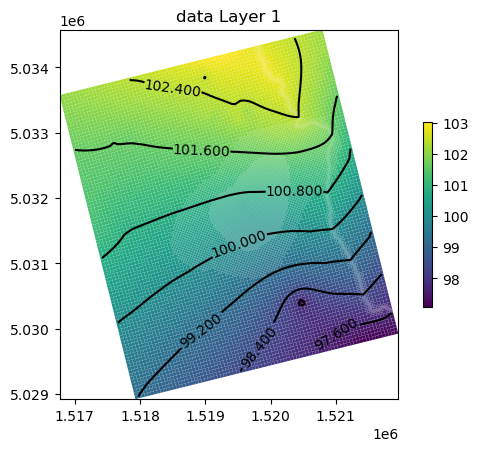

In [11]:
hdtimes = hdobj.get_times()
hdobj.plot(mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)

<Axes: title={'center': 'data Layer 1'}>

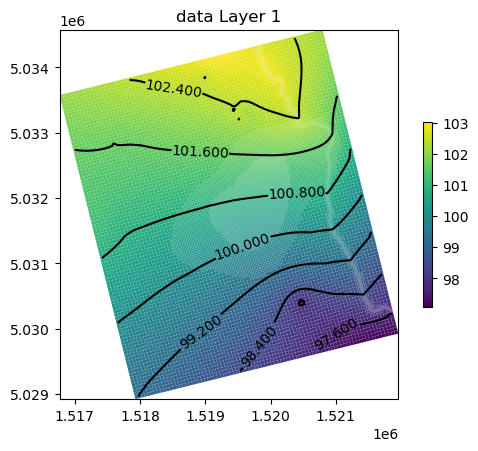

In [12]:
fname2 = os.path.join(hist_workspace, gwf.name + '.hds')
hist_hdobj = flopy.utils.HeadFile(fname2, model=gwf)
hist_hdobj.plot(mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)

In [13]:
hdobj.get_kstpkper()

[(3, 0)]

In [14]:
deltah = hdobj.get_data(mflay=0, kstpkper=(3,0))    -     hist_hdobj.get_data(mflay=0,  kstpkper=(3,0)        )
deltah

array([[-7.98792144e-11, -3.48005358e-08, -6.92414233e-08, ...,
        -6.22071497e-08, -3.09191392e-08, -1.27769795e-10]])

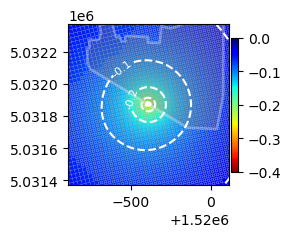

In [15]:
fig = plt.figure(figsize=(3, 3), tight_layout=True)
ax = fig.add_subplot(111, aspect='equal')
ext_offset = 500
extent=(1519614-ext_offset, 1519614+ext_offset, 5031870-ext_offset, 5031870+ext_offset)
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
dh = mm.plot_array(edgecolor='grey', a=deltah[0], cmap='jet_r', alpha=1, linewidth=0.1, vmin=-0.4, vmax=0)
cb = plt.colorbar(dh, shrink=0.5, pad=0.01)                                                # ________________ plot the model grid + fill contours

levels = np.arange(-0.4, 0., 0.05)
cs = mm.contour_array(deltah[0], colors='white', levels=levels)
plt.clabel(cs, fmt='%.1f', colors='white', fontsize=8)                                     # # plot isolines

flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);

In [16]:
fname_mf6 = os.path.join(workspace, list(sim.model_names)[1] + ".ucn")
ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")         # __________ Get the MF6 concentration output

fname_mf6 = os.path.join(hist_workspace, list(sim.model_names)[1] + ".ucn")
hist_ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")    # __________ Pre-hydraulic barrier simulation

deltac = ucnobj_mf6.get_data(mflay=0, kstpkper=(3,0)) - hist_ucnobj_mf6.get_data(mflay=0,  kstpkper=(3,0))    # Difference

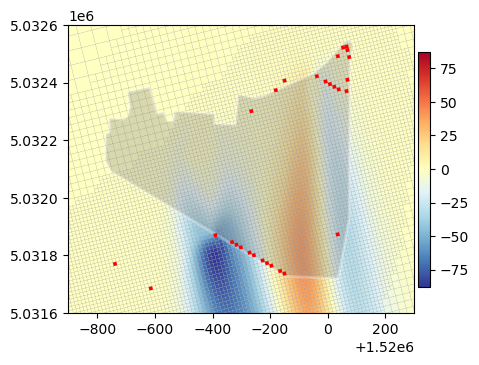

In [17]:
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, aspect='equal')
extent=(1519100, 1520300, 5031600, 5032600) # xmin, xmax    # ymin, ymax

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
a = deltac[0].copy()
vmax = abs(a).max()
vmin = -vmax

dc = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r', alpha=1, linewidth=0.1, vmin=vmin, vmax=vmax)
cb = plt.colorbar(dc, shrink=0.5, pad=0.01)
flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
wells = mm.plot_bc("WEL")